# AMAZON FOOD REVIEW  USING TSNE 

#### i)BOW
#### ii)TFIDF
#### iii)AvgW2v
#### iV)TFIDF-W2v

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

### We are not selecting score which is equal to 3 as it is considered as netural

In [ ]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
def partition(x):
    if x < 3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

### Deleting the duplicates

In [42]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [43]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

#### Here deleting the data where HelpfulnessDenominator is less than HelpfulnessNumerator(partically it is not possible so deleting that lines 

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

### Here I am directly using final.sqlite dataset as it takes long time to compute in my system

In [16]:
conn = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)


#### Here I am taking sample data points of 10

In [117]:
import random
positive_words = final[final['Score']=='positive'].sample(2000)
negative_words = final[final['Score'] == 'negative'].sample(2000)
#print(positive_words.head(5))
#print(negative_words.head(5))

#### Number of positive and negative words are varying a lot.

In [118]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

#### Here we are concatinating the taken sampled postive and negative words to Bow

In [119]:
Bow = pd.concat([positive_words,negative_words])
Bow.shape

(4000, 12)

#### Initialising uni gram

In [120]:
count_vect = CountVectorizer(ngram_range=(1,1))

#### Standardizing the data using StandardScaler 
#### Todense is used to convert the sparse matrix to matrix

In [121]:
standard = StandardScaler(with_mean=False)
sample_data = Bow['CleanedText']
sample_data = count_vect.fit_transform(sample_data)
sample_data = standard.fit_transform(sample_data)
sample_data = sample_data.todense()
labels = Bow['Score']

In [122]:
print(labels.shape)
print(sample_data.shape)

(4000,)
(4000, 9011)


## Using TSNE 
## i)BOW

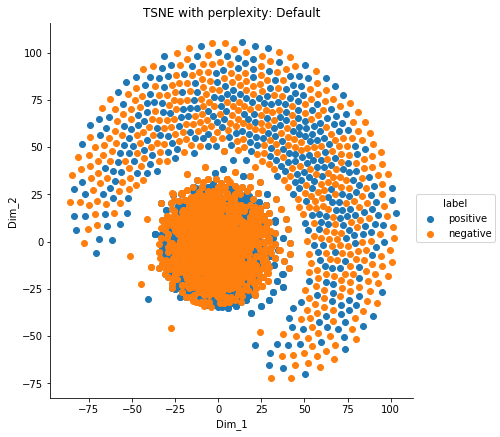

In [123]:
from sklearn.manifold import TSNE
data_10 = sample_data
labels_10 = labels
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: Default")
plt.show()

#### postive and negative words are overlapping on each other we can't get to conclusion by looking in this fig.

#### With Different perplexity

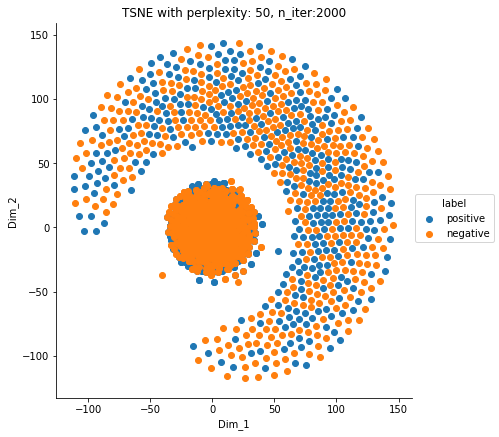

In [124]:
model = TSNE(n_components=2, random_state=0,perplexity = 50,n_iter=2000)
tsne_data = model.fit_transform(data_10)
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 50, n_iter:2000")
plt.show()

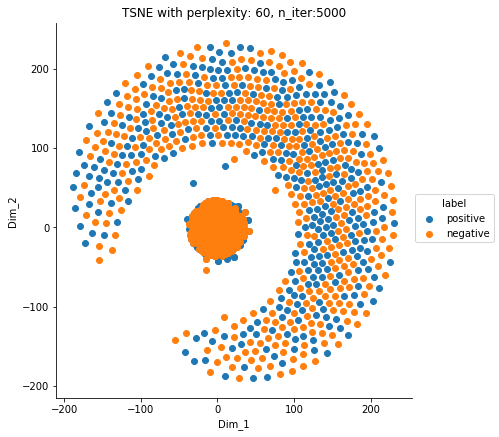

In [125]:
model = TSNE(n_components=2, random_state=0,perplexity = 60, n_iter = 5000)
tsne_data = model.fit_transform(data_10)
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 60, n_iter:5000")
plt.show()

## ii)TFIDF

In [126]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(Bow['CleanedText'].values)
final_tf_idf = final_tf_idf.todense()
tf_idf_labels =labels

In [127]:
print(final_tf_idf.shape)
print(tf_idf_labels.shape)

(4000, 118191)
(4000,)


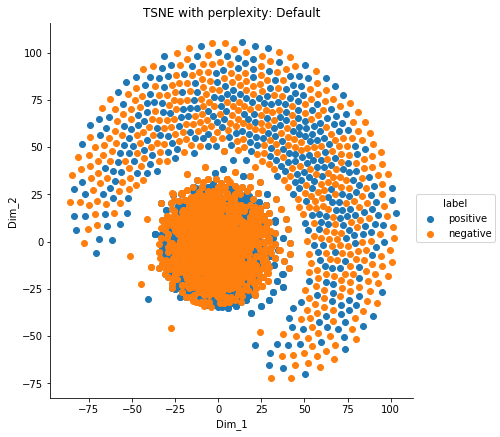

In [128]:
tfdata_10 = sample_data
tflabels_10 = labels
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tfdata_10)
tsne_data = np.vstack((tsne_data.T, tflabels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: Default")
plt.show()

#### with TfIdf also positive and negative words are overlapping  a lot.

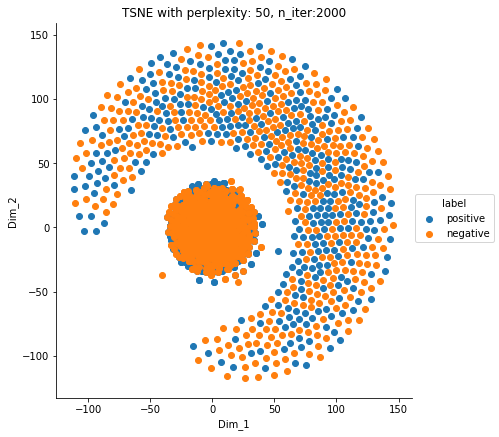

In [129]:
model = TSNE(n_components=2, random_state=0,perplexity = 50,n_iter=2000)
tsne_data = model.fit_transform(tfdata_10)
tsne_data = np.vstack((tsne_data.T, tflabels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 50, n_iter:2000")
plt.show()

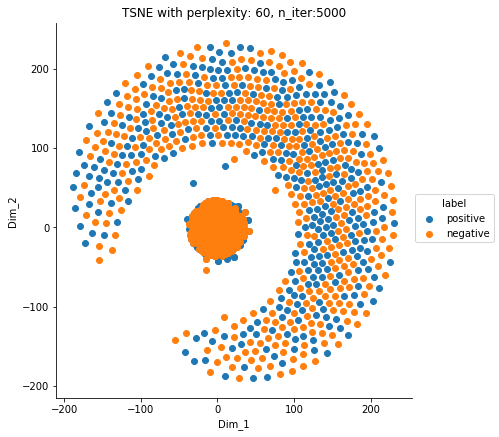

In [130]:
model = TSNE(n_components=2, random_state=0,perplexity = 60, n_iter = 5000)
tsne_data = model.fit_transform(tfdata_10)
tsne_data = np.vstack((tsne_data.T, tflabels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 60, n_iter:5000")
plt.show()

## iii) Word to Vector(W2v) & Avg W2V

In [131]:
i=0
list_of_sent=[]
w2vector = Bow['CleanedText']
w2label = labels.copy()
for sent in w2vector:
    list_of_sent.append(sent.split())

In [132]:
print(list_of_sent[2])

['cat', 'love', 'fanci', 'feast', 'food', 'refus', 'even', 'look', 'brand', 'place', 'dish', 'felin', 'would', 'think', 'would', 'eat', 'anyth', 'cat', 'eat', 'fanci', 'feast', 'martin']


In [133]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [134]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2993
sample words  ['like', 'lot', 'juic', 'tast', 'roast', 'coconut', 'fresh', 'thailand', 'common', 'take', 'natur', 'sweeten', 'ingredi', 'includ', 'ad', 'sugar', 'guess', 'sweet', 'actual', 'prefer', 'minus', 'one', 'star', 'last', 'sip', 'weird', 'dont', 'know', 'also', 'tri', 'vita', 'coco', 'hate', 'life', 'sinc', 'grew', 'tropic', 'area', 'say', 'doesnt', 'brazil', 'probabl', 'differ', 'speci', 'tree', 'mexican', 'condens', 'food', 'made', 'ground']


In [135]:
sent_vectors = []; 
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


 52%|████████████████████████████████████████                                     | 2078/4000 [00:07<00:08, 237.59it/s]


 99%|████████████████████████████████████████████████████████████████████████████▍| 3969/4000 [00:15<00:00, 218.33it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:15<00:00, 253.16it/s]

4000
50


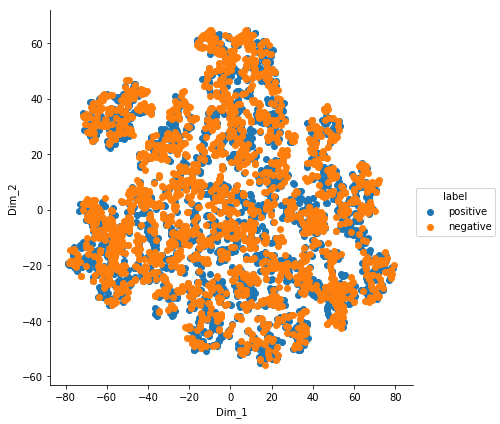

In [136]:
model = TSNE(n_components=2, random_state=0)
w2vector = model.fit_transform(sent_vectors)
tsne_data = np.vstack((w2vector.T, w2label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title("TSNE with perplexity: 60, n_iter:5000")
plt.show()

#### By plotting word2Vec also positive and negative words are overlapping a lot

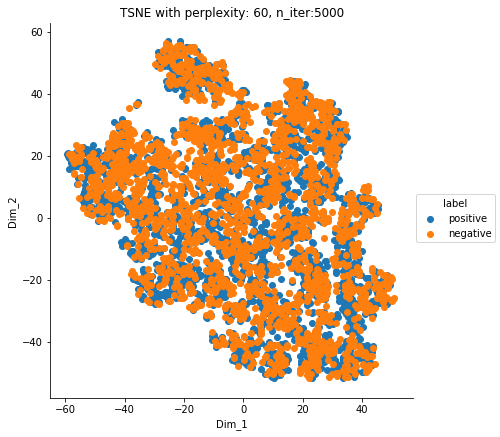

In [137]:
model = TSNE(n_components=2, random_state=0,perplexity = 60, n_iter = 5000)
w2vector = model.fit_transform(sent_vectors)
tsne_data = np.vstack((w2vector.T, w2label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 60, n_iter:5000")
plt.show()

## iV) TFIDF Word 2 Vec

In [140]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(Bow['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [141]:
tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


 41%|███████████████████████████████▋                                             | 1648/4000 [00:07<00:13, 171.39it/s]


 79%|████████████████████████████████████████████████████████████▊                | 3161/4000 [00:15<00:03, 215.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:19<00:00, 207.85it/s]

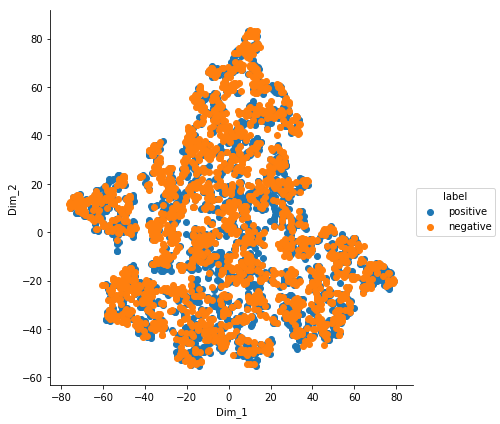

In [142]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### Same thing with TFIDF Word 2 Vec we are not able to see separate positive and negative words

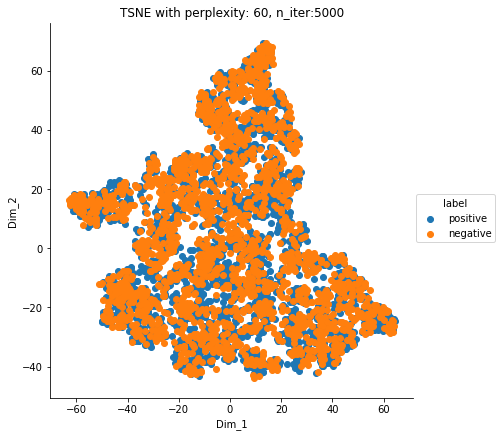

In [143]:
model = TSNE(n_components=2, random_state=0,perplexity = 60, n_iter = 5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with perplexity: 60, n_iter:5000")
plt.show()

# Conclusion

i)BOW

ii)TFIDF

iii)AVGW2V

iV)TFIDF W2V

These are very good algorithms to find the positive and negative words in the review.

But when we are trying to plot the results using TSNE we are not getting the good results.

Most of the positive and negative words are overlapping on each other.

It is very diffcult to differentiate between positive and negative words